In [2]:
""" (LS GAN)
Least Squares GAN

https://arxiv.org/pdf/1611.04076.pdf

Tackles the vanishing gradients problem associated with GANs by swapping out
the cross entropy loss function with the least squares (L2) loss function. The authors
show that minimizing this objective is equivalent to minimizing the Pearson chi-squared 
divergence. They claim that using the L2 loss function penalizes samples that appear to 
be real to the discriminator, but lie far away from the decision boundary. In this way, 
the generated images are made to appear closer to real data. It also stabilizes training.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [24]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Discriminator / Critic (not trained to classify). Input is an image (real or generated), output is P(generated). """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.relu(self.discriminate(activated))
        return discrimination
    
class LSGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator (D) and Generator (G) """
        super(LSGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim)
        
        self.z_dim = z_dim
            
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 1e-4, D_lr = 1e-4, D_steps = 2):
        """ Train a Least Squares GAN
            Logs progress using G loss, D loss, visualizations of Generator output.

        Inputs:
            model: class, initialized LSGAN module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 2)
        Outputs:
            model: trained LSGAN instance """
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using samples from the generator, compute sigmoid cross entropy loss to get D_loss = loss(D(x)) + loss(D(G(x)))
                    D_loss = self.train_D(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss)
                
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                                                        
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator using predictions from D on the noise compared to true image labels
                # (learn to generate examples from noise that fool the discriminator)   
                G_loss = self.train_G(model, images)             

                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images):
        """ Run 1 step of training for discriminator
            
            G_noise = randomly generated noise, x'
            G_output = G(x'), generated images from noise
            DX_score = D(x), probability x is generated where x are real images
            DG_score = D(G(x')), probability G(x') is a generation where x' is noise
        """      
        
        # ORIGINAL CRITIC STEPS:
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = model.D(images) # D(x), "real"
        DG_score = model.D(G_output) # D(G(x')), "fake"
        
        # Compute L2 loss
        D_loss = 0.5 * (torch.mean((DX_score - 1)**2) + torch.mean(DG_score**2))
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
            G_noise = randomly generated noise, x'
            G_output = G(x')
            DG_score = D(G(x'))
        """
        # Get noise, classify it using G, then classify the output of G using D.
        G_noise = self.compute_noise(images.shape[0], model.z_dim) # x'
        G_output = model.G(G_noise) # G(x')
        DG_score = model.D(G_output) # D(G(x'))
        
        # Compute L2 loss
        G_loss = 0.5 * torch.mean((DG_score - 1)**2)
        
        return DG_score
    
    def compute_noise(self, batch_size, image_size):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, image_size))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/ls-gan/'):
                os.makedirs('../viz/ls-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/ls-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = LSGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model

Epoch[1/100], G cost: 0.4986, D cost: 0.0073



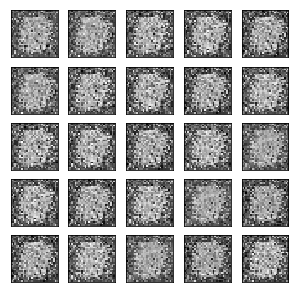

Epoch[2/100], G cost: 0.4999, D cost: 0.0005


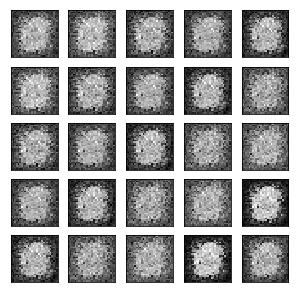

Epoch[3/100], G cost: 0.4980, D cost: 0.0017


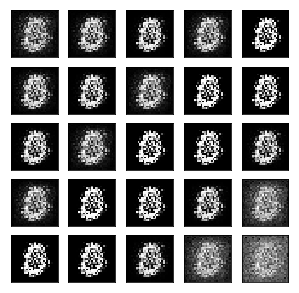

Epoch[4/100], G cost: 0.4970, D cost: 0.0030


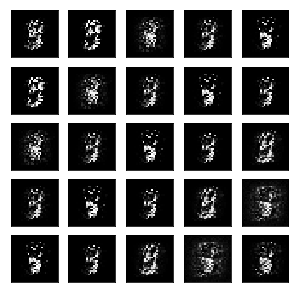

Epoch[5/100], G cost: 0.4969, D cost: 0.0034


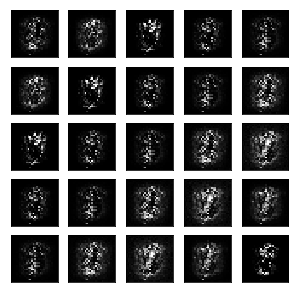

Epoch[6/100], G cost: 0.4979, D cost: 0.0019


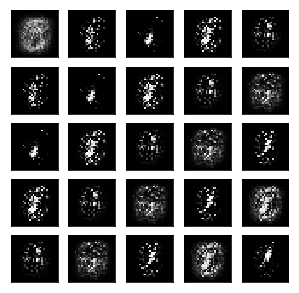

Epoch[7/100], G cost: 0.4968, D cost: 0.0021


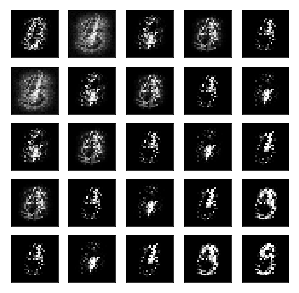

Epoch[8/100], G cost: 0.4935, D cost: 0.0042


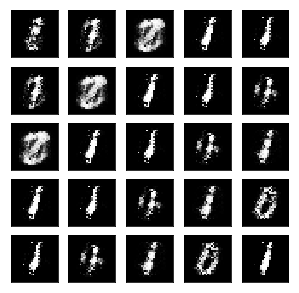

Epoch[9/100], G cost: 0.4889, D cost: 0.0077


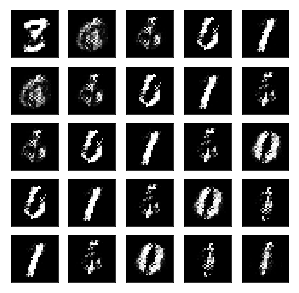

Epoch[10/100], G cost: 0.4841, D cost: 0.0094


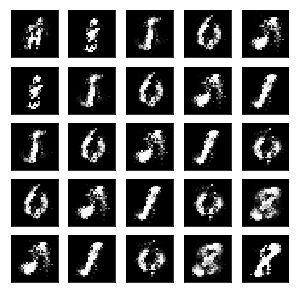

Epoch[11/100], G cost: 0.4809, D cost: 0.0117


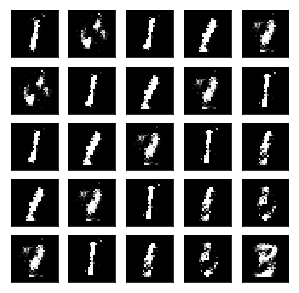

Epoch[12/100], G cost: 0.4773, D cost: 0.0135


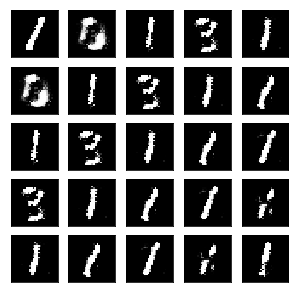

Epoch[13/100], G cost: 0.4723, D cost: 0.0162


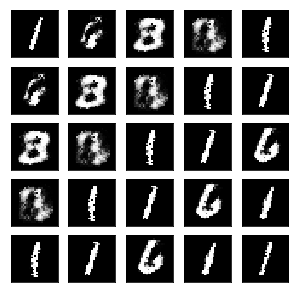

Epoch[14/100], G cost: 0.4695, D cost: 0.0181


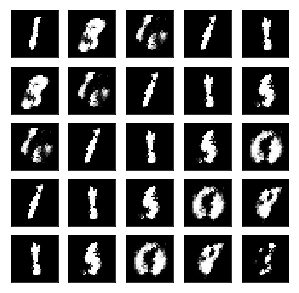

Epoch[15/100], G cost: 0.4657, D cost: 0.0207


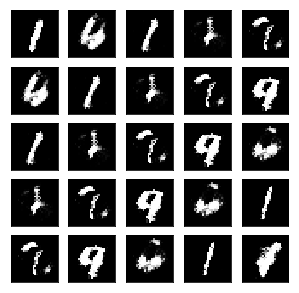

Epoch[16/100], G cost: 0.4628, D cost: 0.0222


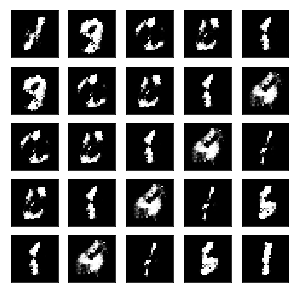

Epoch[17/100], G cost: 0.4610, D cost: 0.0233


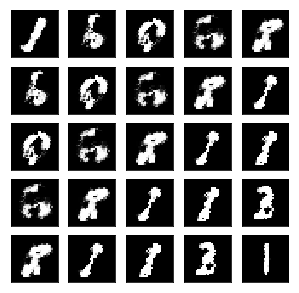

Epoch[18/100], G cost: 0.4597, D cost: 0.0237


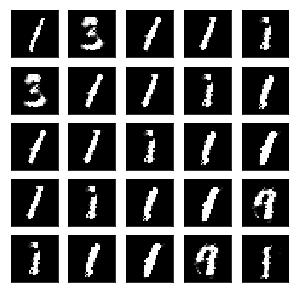

Epoch[19/100], G cost: 0.4597, D cost: 0.0235


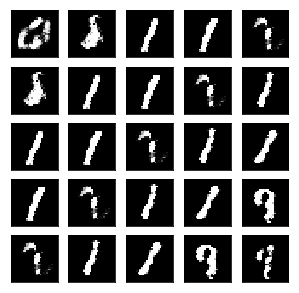

Epoch[20/100], G cost: 0.4609, D cost: 0.0234


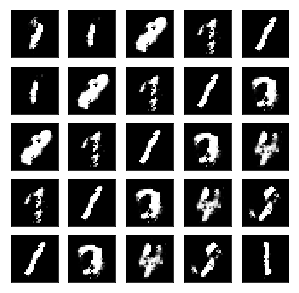

Epoch[21/100], G cost: 0.4618, D cost: 0.0225


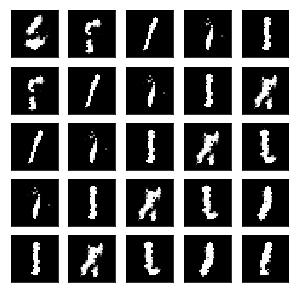

Epoch[22/100], G cost: 0.4619, D cost: 0.0218


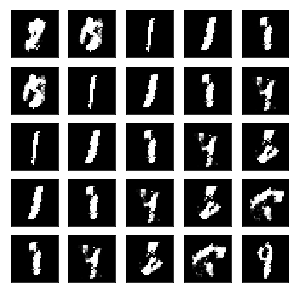

Epoch[23/100], G cost: 0.4636, D cost: 0.0218


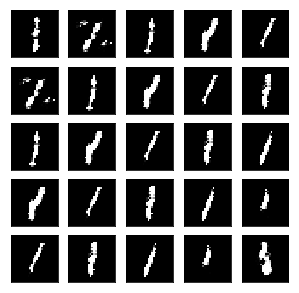

Epoch[24/100], G cost: 0.4639, D cost: 0.0205


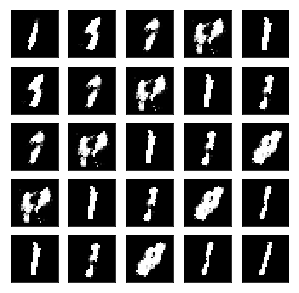

Epoch[25/100], G cost: 0.4637, D cost: 0.0209


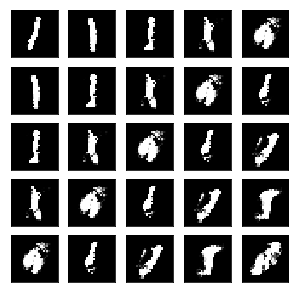

Epoch[26/100], G cost: 0.4668, D cost: 0.0212


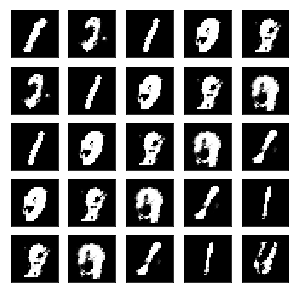

Epoch[27/100], G cost: 0.4647, D cost: 0.0204


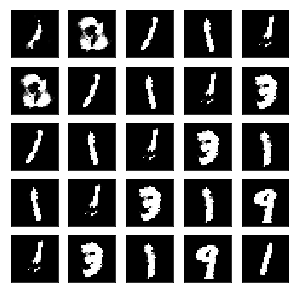

Epoch[28/100], G cost: 0.4651, D cost: 0.0202


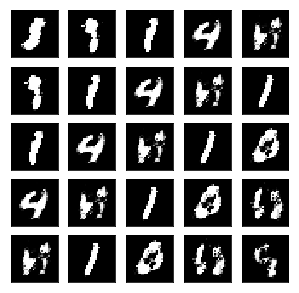

Epoch[29/100], G cost: 0.4662, D cost: 0.0203


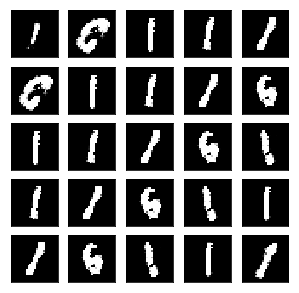

Epoch[30/100], G cost: 0.4650, D cost: 0.0200


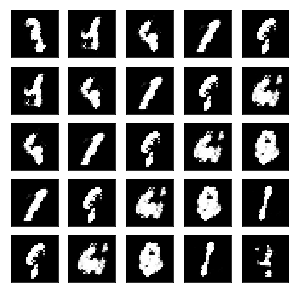

Epoch[31/100], G cost: 0.4662, D cost: 0.0197


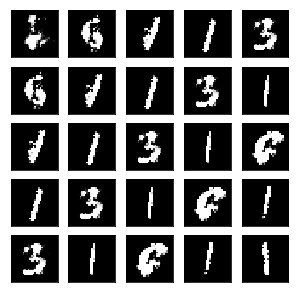

Epoch[32/100], G cost: 0.4667, D cost: 0.0194


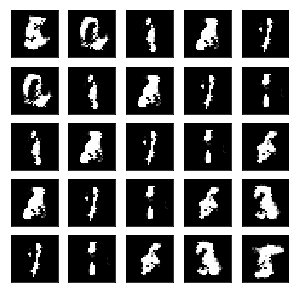

Epoch[33/100], G cost: 0.4670, D cost: 0.0192


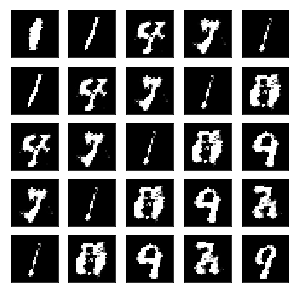

Epoch[34/100], G cost: 0.4670, D cost: 0.0197


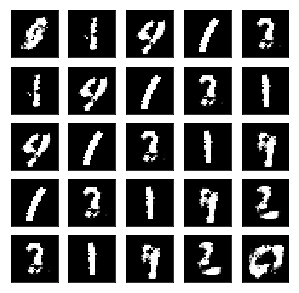

Epoch[35/100], G cost: 0.4666, D cost: 0.0193


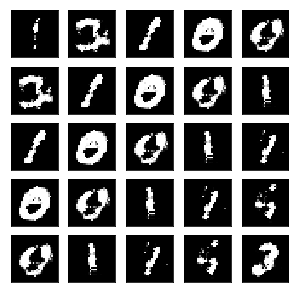

Epoch[36/100], G cost: 0.4660, D cost: 0.0200


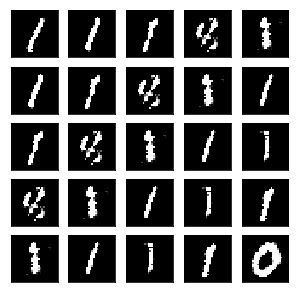

Epoch[37/100], G cost: 0.4663, D cost: 0.0201


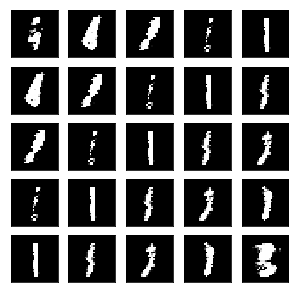

Epoch[38/100], G cost: 0.4670, D cost: 0.0196


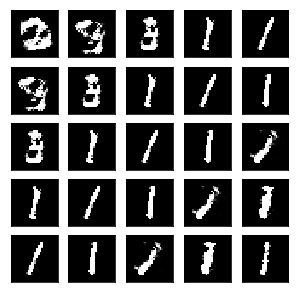

Epoch[39/100], G cost: 0.4662, D cost: 0.0196


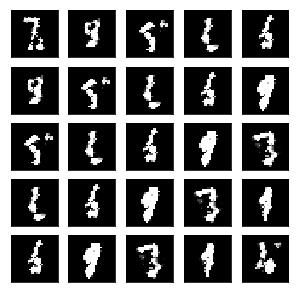

Epoch[40/100], G cost: 0.4677, D cost: 0.0192


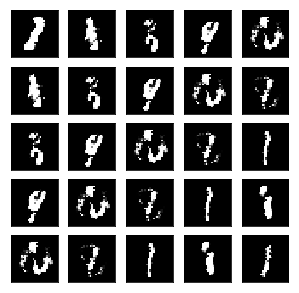

Epoch[41/100], G cost: 0.4663, D cost: 0.0196


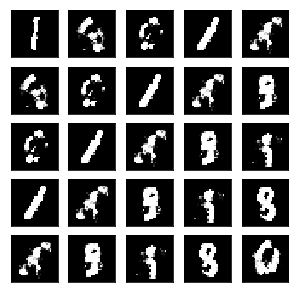

Epoch[42/100], G cost: 0.4677, D cost: 0.0197


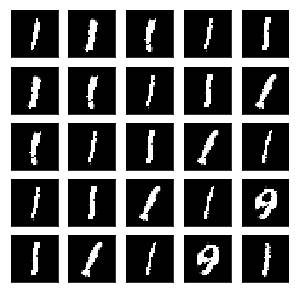

Epoch[43/100], G cost: 0.4652, D cost: 0.0202


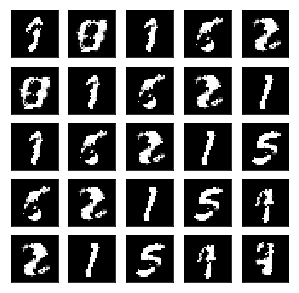

Epoch[44/100], G cost: 0.4655, D cost: 0.0204


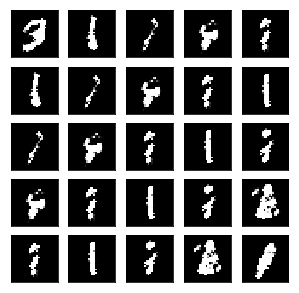

Epoch[45/100], G cost: 0.4664, D cost: 0.0193


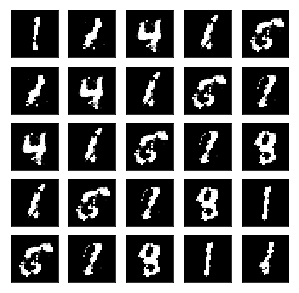

Epoch[46/100], G cost: 0.4677, D cost: 0.0191


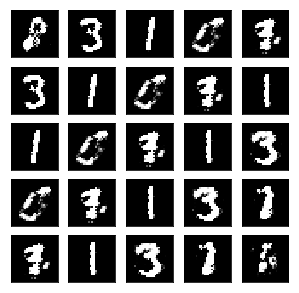

Epoch[47/100], G cost: 0.4666, D cost: 0.0192


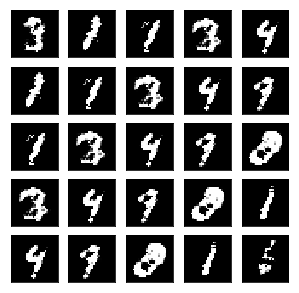

Epoch[48/100], G cost: 0.4679, D cost: 0.0197


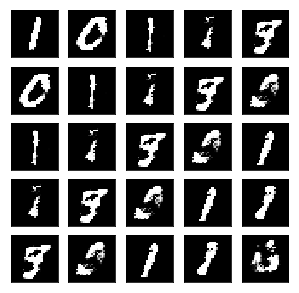

Epoch[49/100], G cost: 0.4665, D cost: 0.0192


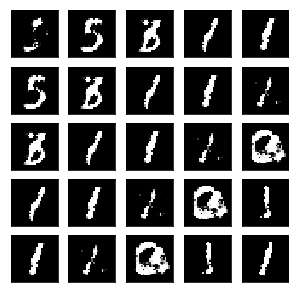

Epoch[50/100], G cost: 0.4660, D cost: 0.0197


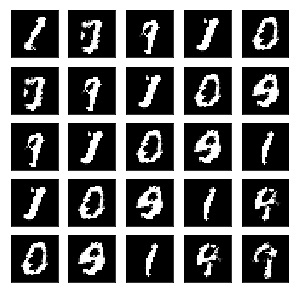

Epoch[51/100], G cost: 0.4656, D cost: 0.0203


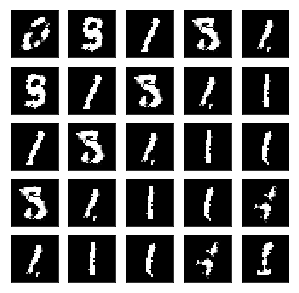

Epoch[52/100], G cost: 0.4664, D cost: 0.0199


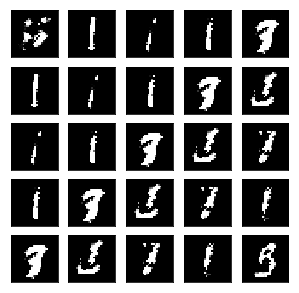

Epoch[53/100], G cost: 0.4660, D cost: 0.0198


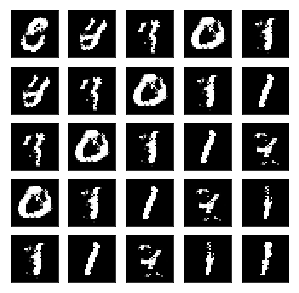

Epoch[54/100], G cost: 0.4676, D cost: 0.0200


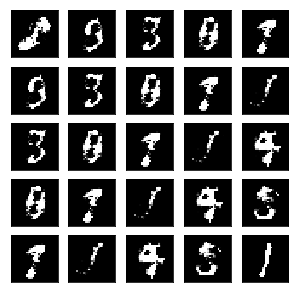

Epoch[55/100], G cost: 0.4666, D cost: 0.0200


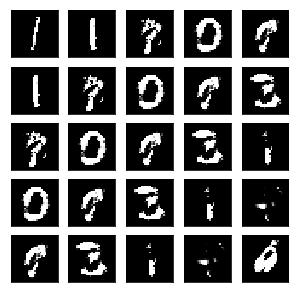

Epoch[56/100], G cost: 0.4670, D cost: 0.0199


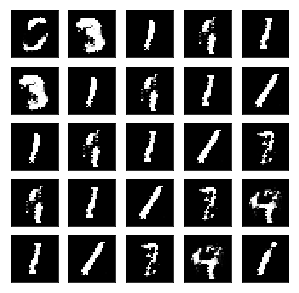

Epoch[57/100], G cost: 0.4662, D cost: 0.0197


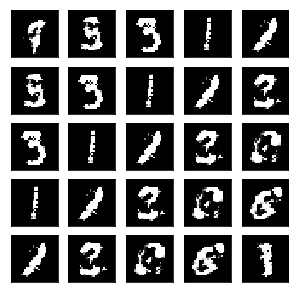

Epoch[58/100], G cost: 0.4646, D cost: 0.0205


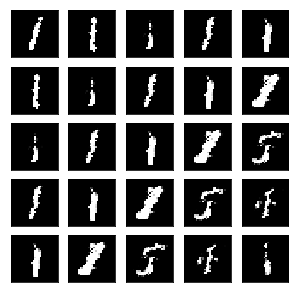

Epoch[59/100], G cost: 0.4665, D cost: 0.0203


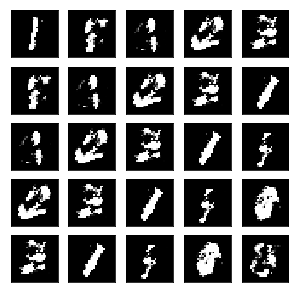

Epoch[60/100], G cost: 0.4678, D cost: 0.0203


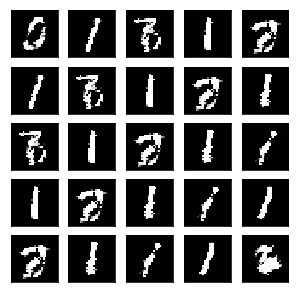

Epoch[61/100], G cost: 0.4648, D cost: 0.0203


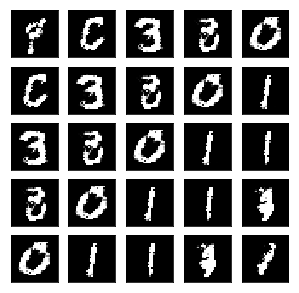

Epoch[62/100], G cost: 0.4663, D cost: 0.0199


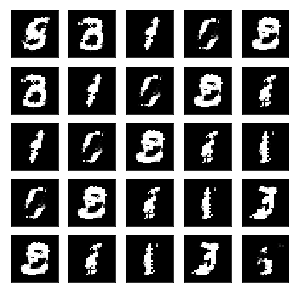

Epoch[63/100], G cost: 0.4657, D cost: 0.0210


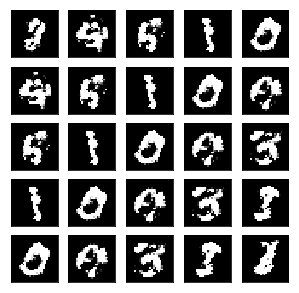

Epoch[64/100], G cost: 0.4654, D cost: 0.0202


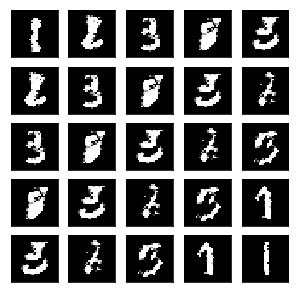

KeyboardInterrupt: 

In [26]:
model = LSGAN(image_size = 784, hidden_dim = 256, z_dim = 100)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 100, G_lr = 1e-3, D_lr = 1e-3, D_steps = 3)